# ***Load Data***

In [2]:
import pandas  as pd
import numpy   as np
import xgboost as xgb


train_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv',index_col=0)
test_data  = pd.read_csv('house-prices-advanced-regression-techniques/test.csv',index_col=0)

***Splitting Data to Train and Test***

In [3]:
X_train = train_data.drop(['SalePrice'], axis=1)
y_train = train_data['SalePrice']
X_test = test_data

***Removing Categories that are not integers***

In [4]:
categories = X_train.dtypes[(X_train.dtypes == 'int') | (X_train.dtypes == 'float')].index.tolist()
X_train = X_train[categories]
X_test = X_test[categories]

***Removing Features that have Nulls***

In [5]:
X_train.isnull().sum()

MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

In [6]:
X_train = X_train.drop(['LotFrontage', 'GarageYrBlt', 'MasVnrArea'], axis=1)
X_test = X_test.drop(['LotFrontage', 'GarageYrBlt', 'MasVnrArea'], axis=1)

***Feature Selection***

In [7]:
from BorutaShap import BorutaShap

feature_selector = BorutaShap(importance_measure='shap', classification=False )
feature_selector.fit(X=X_train, y=y_train, n_trials=20)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 20/20 [06:27<00:00, 19.37s/it]

17 attributes confirmed important: ['MSSubClass', 'GarageCars', 'YearBuilt', 'OpenPorchSF', 'OverallQual', 'BsmtUnfSF', 'LotArea', '1stFlrSF', 'TotalBsmtSF', 'Fireplaces', 'OverallCond', 'GarageArea', 'BsmtFinSF1', 'WoodDeckSF', 'YearRemodAdd', 'GrLivArea', '2ndFlrSF']
13 attributes confirmed unimportant: ['MoSold', 'BedroomAbvGr', 'HalfBath', 'MiscVal', 'EnclosedPorch', 'PoolArea', 'YrSold', 'BsmtFinSF2', 'BsmtFullBath', 'LowQualFinSF', 'ScreenPorch', 'BsmtHalfBath', '3SsnPorch']
3 tentative attributes remains: ['KitchenAbvGr', 'FullBath', 'TotRmsAbvGrd']


In [8]:
X_train = X_train[['GarageCars', 'OverallQual', 'YearBuilt', 'OverallCond', 'Fireplaces', 'GrLivArea', 'BsmtFinSF1', 'MSSubClass', 'GarageArea', 'OpenPorchSF', 'WoodDeckSF', 'YearRemodAdd', 'LotArea', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF']]
X_test = X_test[['GarageCars', 'OverallQual', 'YearBuilt', 'OverallCond', 'Fireplaces', 'GrLivArea', 'BsmtFinSF1', 'MSSubClass', 'GarageArea', 'OpenPorchSF', 'WoodDeckSF', 'YearRemodAdd', 'LotArea', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF']]

***Feature Engineering***

In [9]:
# Creating new feature of a combination of quality and condition

for df in (X_train, X_test):
    df['OverallState'] = df['OverallQual'] + df['OverallCond']

***Grid Search on XGBoost***

In [10]:
regressor=xgb.XGBRegressor(eval_metric='rmsle')

from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

In [11]:
search = GridSearchCV(regressor, param_grid)

search.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmsle', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.015], 'max_depth': [4, 5],
                         'n_estimators': [500, 600, 700]})

In [12]:
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 700}


***Create Model from Grid Search***

In [13]:
model = xgb.XGBRegressor(max_depth=4, learning_rate=0.015, n_estimators=700)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

***Run on Test Set***

In [14]:
predictions = model.predict(X_test)

***Creating Submission for Kaggle***

In [15]:
output = pd.DataFrame({"Id":test_data.index, "SalePrice":predictions})
output.to_csv('submission.csv', index=False)

***Feature Importance using F Score***

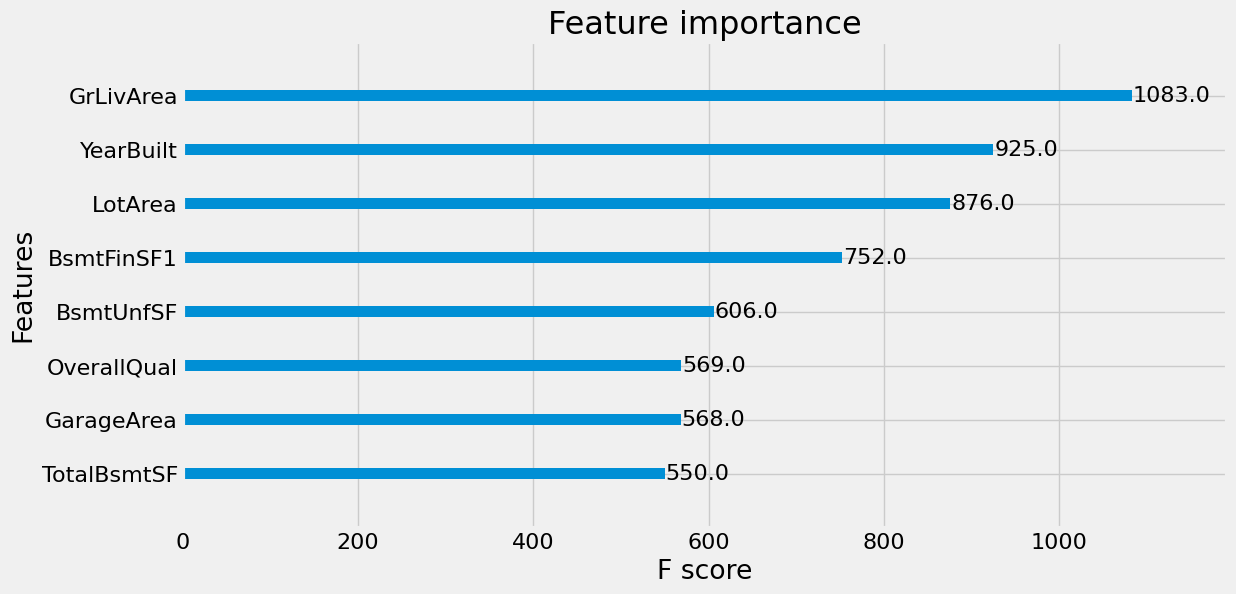

In [16]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(model, max_num_features=8, ax=ax)
plt.show();

***Feature Importance using Shap***

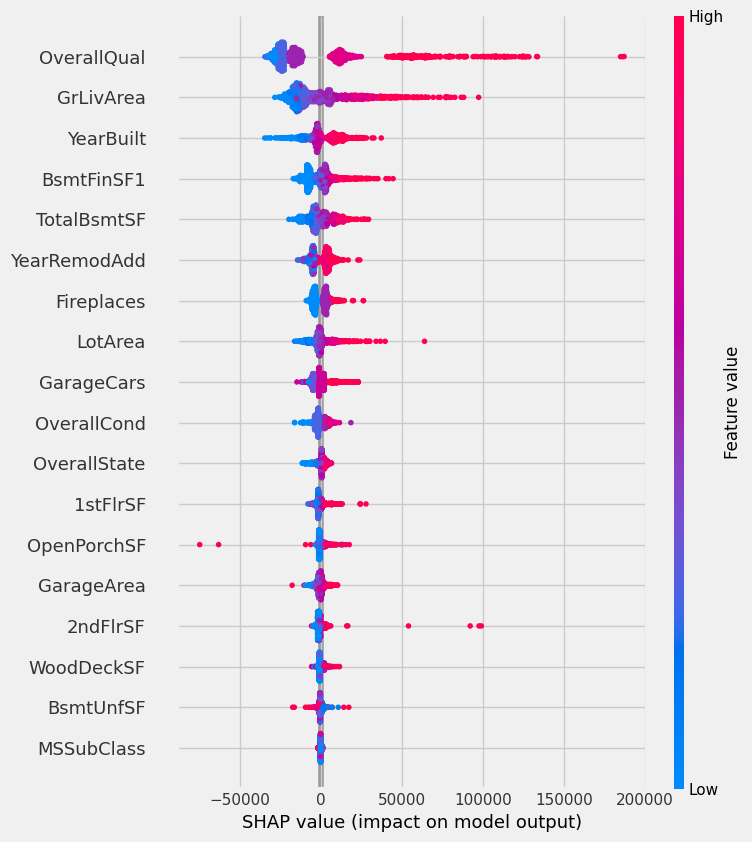

In [17]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)